In [52]:
import SimpleITK as sitk
import registration_gui as rgui
import utilities
import gui
from ipywidgets import interact, fixed

import matplotlib.pyplot as plt
import numpy as np

In [53]:
def make_isotropic(image, interpolator = sitk.sitkLinear):
    '''
    Resample an image to isotropic pixels (using smallest spacing from original) and save to file. Many file formats
    (jpg, png,...) expect the pixels to be isotropic. By default the function uses a linear interpolator. For
    label images one should use the sitkNearestNeighbor interpolator so as not to introduce non-existant labels.
    '''
    original_spacing = image.GetSpacing()
    # Image is already isotropic, just return a copy
    if all(spc == original_spacing[0] for spc in original_spacing):
        return sitk.Image(image)
    # Make image isotropic via resampling
    original_size = image.GetSize()
    min_spacing = min(original_spacing)
    new_spacing = [min_spacing]*image.GetDimension()
    new_size = [int(round(osz*ospc/min_spacing)) for osz,ospc in zip(original_size, original_spacing)]
    return sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

data path 

In [54]:
# chest image path
chest_dpath = r'data\chestctdata'
chest_fixed_path = r'data\chestctdata\01_Fixed.mhd'
chest_moving_path = r'data\chestctdata\01_Moving.mhd'

# lung image path 
lung_dpath = r'data\lungMasks'
lung_fixed_path = r'data\lungMasks\01_Fixed.mhd'
lung_moving_path = r'data\lungMasks\01_Moving.mhd'

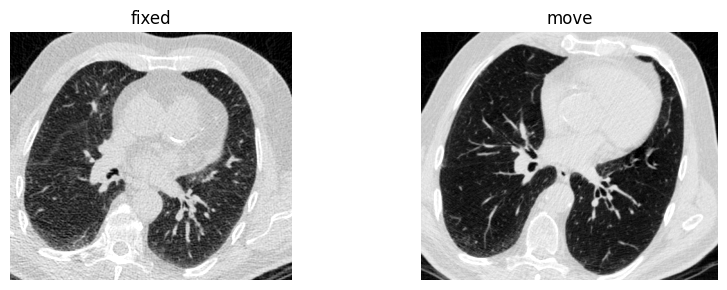

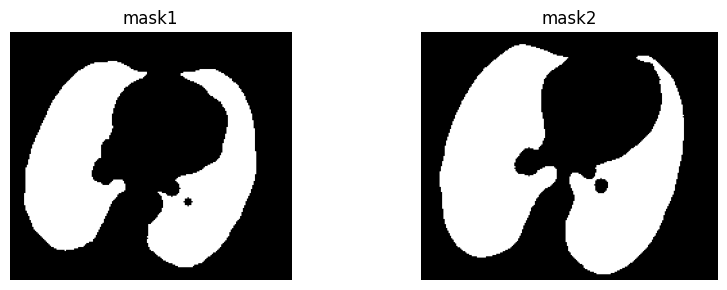

In [55]:
# Display chest images
chest_fixed = sitk.ReadImage(chest_fixed_path)
chest_moving = sitk.ReadImage(chest_moving_path)

# display lung masks 
lung_fixed = sitk.ReadImage(lung_fixed_path)
lung_moving = sitk.ReadImage(lung_moving_path)



# display images
gui.MultiImageDisplay(image_list=[chest_fixed,chest_moving],
                      title_list=['fixed','move'],
                      figure_size=(9,3))

gui.MultiImageDisplay(image_list=[lung_fixed,lung_moving],
                      title_list=['mask1','mask2'],
                      figure_size=(9,3))


cast images to same intensity and find segmentation 

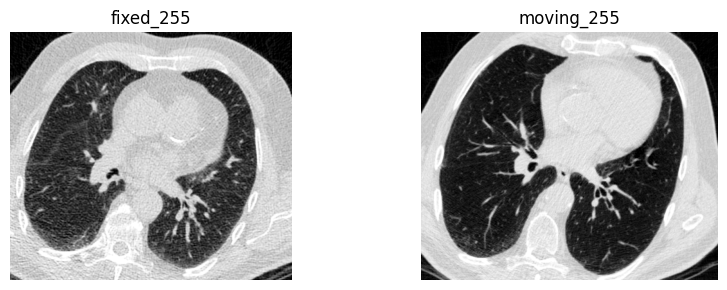

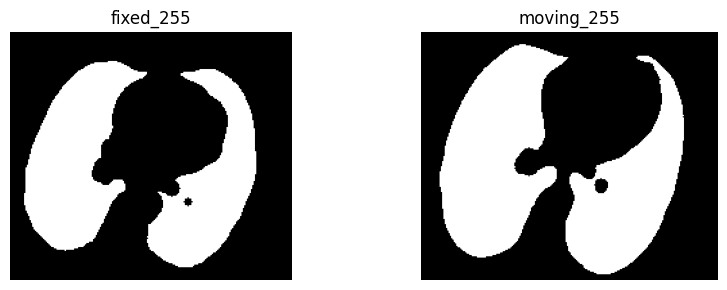

In [56]:
# prepare data for processing 

# for chest fixed image the intensity is : −1020 – 385
fixed_255 = sitk.Cast(sitk.IntensityWindowing(chest_fixed, windowMinimum=-1020, windowMaximum=385,
                        outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

# for chest moving image the intensity is : −1006 – 300
moving_255 = sitk.Cast(sitk.IntensityWindowing(chest_moving, windowMinimum=-1006, windowMaximum=300,
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

fixed_mask = sitk.Cast(sitk.IntensityWindowing(lung_fixed, windowMinimum=0, windowMaximum=1,
                        outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
moving_mask = sitk.Cast(sitk.IntensityWindowing(lung_moving, windowMinimum=0, windowMaximum=1,
                        outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)


gui.MultiImageDisplay(image_list = [fixed_255, moving_255],
                      title_list = ['fixed_255', 'moving_255'],
                      figure_size=(9,3))

gui.MultiImageDisplay(image_list = [fixed_mask, moving_mask],
                      title_list = ['fixed_255', 'moving_255'],
                      figure_size=(9,3))


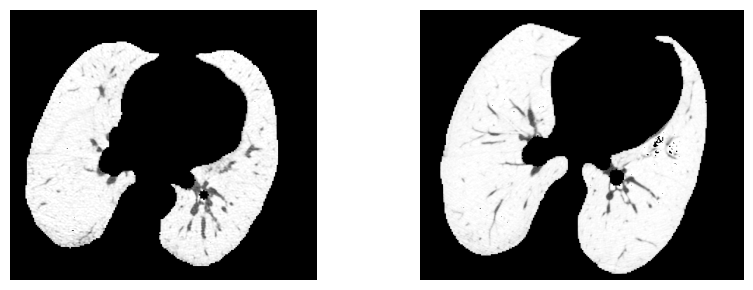

In [57]:
fixed_image = fixed_mask*fixed_255
moving_image = moving_mask*moving_255

gui.MultiImageDisplay(image_list = [fixed_image, moving_image],figure_size=(9,3))

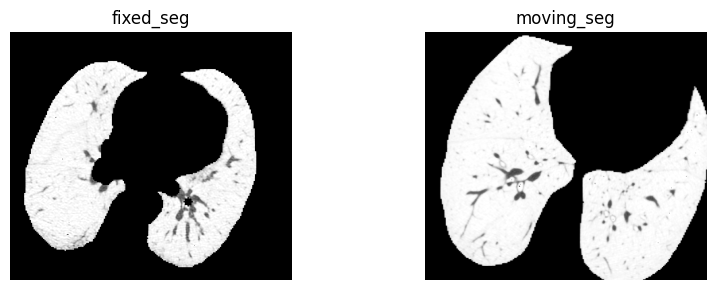

In [58]:

moving_image = sitk.Resample(moving_image, fixed_image, sitk.Transform(), sitk.sitkLinear, 0, moving_image.GetPixelID())
gui.MultiImageDisplay(image_list = [fixed_image, moving_image],
                      title_list = ['fixed_seg', 'moving_seg'],
                      figure_size=(9,3))

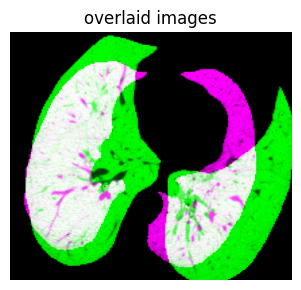

In [59]:

# cast to 255
# for chest fixed image the intensity is : 0– 228
fixed = sitk.Cast(sitk.IntensityWindowing(fixed_image, windowMinimum=0, windowMaximum=228,
                        outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

# for chest moving image the intensity is : 0-243
moving = sitk.Cast(sitk.IntensityWindowing(moving_image, windowMinimum=0, windowMaximum=242,
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

fixed = make_isotropic(fixed)
moving = make_isotropic(moving)

# Combine fixed and moving images
combined_image = sitk.Cast(sitk.Compose(fixed, moving, fixed), sitk.sitkVectorUInt8)

gui.MultiImageDisplay(image_list = [combined_image],
                      title_list = ['overlaid images'],
                      figure_size=(9,3))